# Final Project

* DS 5001
* Amber Curran
* akc6be

# Overview

Data was obtained from Project Gutenberg to explore the texts of the most popular and well known literature as downloaded from the site. These include those counted as the top 5 downloaded pieces of literature downloaded in the last 30 days as of today. Analysis through different text structures, terms, and sentiments are explored below. Visualizations for the code is shown at the very end and included in the supplimental report.

# Set Up

## F0: Acquire Source Texts

The novels were obtained from Project Gutenberg in their list of all books sorted by popularity. Therefore, these are the top 5 most downloaded books in the last 30 days within the Project Gutenberg database:

1. **Frankenstein; Or, The Modern Prometheus** by Mary Wollstonecraft Shelley --ID 11 (80658 downloads)
2. **Pride and Prejudice** by Jane Austen --ID 1342 (56494 downloads)
3. **A Christmas Carol in Prose; Being a Ghost Story of Christmas** by Charles Dickens --ID 25344 (44543 downloads)
4. **The Scarlet Letter** by Nathaniel Hawthorne --ID 46 (35961 downloads)
5. **Alice's Adventures in Wonderland** by Lewis Carroll --ID 84 (26460 downloads)

## Configs

Define OCHO and directory of texts used for most of the code below.

In [1]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

SENT = OHCO[:4]
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

epub_dir = 'texts'

## Imports

Import all necessary modules for most of the code below.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from glob import glob
import re
import nltk

In [3]:
sns.set()
%matplotlib inline

## Inspect

Since Project Gutenberg texts vary widely in their markup, I defined the chunking patterns by hand.

In [4]:
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
chap_pats = {
    11: {
        'start_line': 31,
        'end_line': 3406,
        'chapter': re.compile("^\s*CHAPTER\s+{}\.".format(roman))
    },
    1342: {
        'start_line': 37,
        'end_line': 14230,
        'chapter': re.compile("^Chapter\s+\d+$")
    },
    25344: {
        'start_line': 1611,
        'end_line': 8721,
        'chapter': re.compile("^\s*{}\.".format(roman))          
    },
    46: {
        'start_line': 29,
        'end_line': 3872,
        'chapter': re.compile("^\s*STAVE\s+{}\:".format(roman))
    },
    84: {
        'start_line': 31,
        'end_line': 7389,
        'chapter': re.compile("^Chapter\s+\d+$")

    }
}

## F0:

All text files downloaded from Project Gutenberg are included in the UVA Box folder called "texts".

## F1:

Create a corpus of all documents. These documents are read into a dataframe including each line number and line text.

In [5]:
# Get list of documents
epubs = [epub for epub in sorted(glob(epub_dir+'/*.txt'))]

# Create an empty dataframe
df = pd.DataFrame()

# Loop through documents to add text all on one dataframe with indicated line and book ID
for epub_file in epubs:
        
        # Get ID from filename
        book_id = int(epub_file.split('.')[0].replace('texts/',''))
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        subdf = pd.DataFrame(lines, columns=['line_str'])
        subdf.index.name = 'line_num'
        subdf.line_str = subdf.line_str.str.strip()
        subdf['book_id'] = book_id
        
        # Set book_id as index
        subdf = subdf.reset_index().set_index('book_id')
        
        # Append to empty dataframe
        df = df.append(subdf)

df

line_num                                           line_str
book_id                                                             
11              0  The Project Gutenberg eBook of Alice’s Adventu...
11              1                                                   
11              2  This eBook is for the use of anyone anywhere i...
11              3  most other parts of the world at no cost and w...
11              4  whatsoever. You may copy it, give it away or r...
...           ...                                                ...
84           7738  including how to make donations to the Project...
84           7739  Archive Foundation, how to help produce our ne...
84           7740  subscribe to our email newsletter to hear abou...
84           7741                                                   
84           7742                                                   

[39400 rows x 2 columns]

## F2: 

F2 was created by registering and chunking each book into the DOC dataframe to only include the block of text that is the text of the book without any markup. It was further parsed into each paragraph. The LIB table includes basic information on the book id, author, and title. The TOKEN table was created by listing each term and using nltk to determine the part of speech associated with the word for each word in each book. The VOCAB table includes each term and the number of times each is included in the corpus.

In [6]:
def acquire_epubs(epub_list, chap_pats, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in epub_list:
        
        # Get ID from filename
        book_id = int(epub_file.split('.')[0].replace('texts/',''))
        print("BOOK ID", book_id)
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = book_id
        
        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.line_str = df.line_str.str.replace('—', ' — ')
        df.line_str = df.line_str.str.replace('-', ' - ')
        
        # Get book title and put into LIB table -- note problems, though
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[0].line_str, flags=re.IGNORECASE)
        book_title = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        
        # Remove cruft
        a = chap_pats[book_id]['start_line'] - 1
        b = chap_pats[book_id]['end_line'] + 1
        df = df.iloc[a:b]
        
        # Chunk by chapter
        chap_lines = df.line_str.str.match(chap_pats[book_id]['chapter'])
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        df.loc[chap_lines, 'chap_num'] = chap_nums
        df.chap_num = df.chap_num.ffill()

        # Clean up
        df = df[~df.chap_num.isna()] # Remove chapter heading lines
        df = df.loc[~chap_lines] # Remove everything before Chapter 1
        df['chap_num'] = df['chap_num'].astype('int')
        
        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        df['para_str'] = df['para_str'].str.replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs
        
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id, book_title, epub_file))
        my_doc.append(df)

    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'book_title', 'book_file']).set_index('book_id')
    return library, docs

Prints all book IDs that verify which books are added into each table.

In [7]:
epubs = [epub for epub in sorted(glob(epub_dir+'/*.txt'))]
LIB, DOC = acquire_epubs(epubs, chap_pats)

BOOK ID 11
BOOK ID 1342
BOOK ID 25344
BOOK ID 46
BOOK ID 84


**LIB table**

In [8]:
# Print LIB table sample
LIB

book_title        book_file
book_id                                                                    
11       Alice’s Adventures in Wonderland, by Lewis Car...     texts/11.txt
1342                   Pride and Prejudice, by Jane Austen   texts/1342.txt
25344           The Scarlet Letter, by Nathaniel Hawthorne  texts/25344.txt
46                   A Christmas Carol, by Charles Dickens     texts/46.txt
84       Frankenstein, by Mary Wollstonecraft (Godwin) ...     texts/84.txt

In [9]:
# Split the author and title into their own columns
LIB['author'] = LIB.book_title.str.split(', by').apply(lambda x: x[1])
LIB['title'] = LIB.book_title.str.split(', by').apply(lambda x: x[0])
LIB

book_title        book_file  \
book_id                                                                       
11       Alice’s Adventures in Wonderland, by Lewis Car...     texts/11.txt   
1342                   Pride and Prejudice, by Jane Austen   texts/1342.txt   
25344           The Scarlet Letter, by Nathaniel Hawthorne  texts/25344.txt   
46                   A Christmas Carol, by Charles Dickens     texts/46.txt   
84       Frankenstein, by Mary Wollstonecraft (Godwin) ...     texts/84.txt   

                                        author  \
book_id                                          
11                               Lewis Carroll   
1342                               Jane Austen   
25344                      Nathaniel Hawthorne   
46                             Charles Dickens   
84        Mary Wollstonecraft (Godwin) Shelley   

                                    title  
book_id                                    
11       Alice’s Adventures in Wonderland  
1342                  Pride and Prejudice  
25344                  The Scarlet Letter  
46                      A Christmas Carol  
84                           Frankenstein

**DOC table**

In [10]:
# Print DOC table sample
DOC.sample(5)

para_str
book_id chap_num para_num                                                   
84      31       30        I remained motionless. The thunder ceased; but...
1342    101      29        But as Elizabeth could not receive comfort fro...
        108      18        It may be easily believed, that however little...
11      21       45                         “What _is_ the fun?” said Alice.
1342    113      15        “Mr. Darcy was punctual in his return, and as ...

**TOKEN Table**

In [11]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [12]:
# Use the tokenize function to create a new TOKEN table
TOKEN = tokenize(DOC, ws=True)

In [13]:
# Print TOKEN table sample
TOKEN.sample(5)

pos_tuple  pos  \
book_id chap_num para_num sent_num token_num                          
25344   8        35       1        78         (gentleness, NN)   NN   
84      47       10       1        27           (chamber., NN)   NN   
25344   9        13       4        43              (among, IN)   IN   
1342    118      13       4        22                (the, DT)   DT   
84      40       7        2        6           (remained, VBD)  VBD   

                                               token_str  
book_id chap_num para_num sent_num token_num              
25344   8        35       1        78         gentleness  
84      47       10       1        27           chamber.  
25344   9        13       4        43              among  
1342    118      13       4        22                the  
84      40       7        2        6            remained

**VOCAB table**

In [14]:
# Use the TOKEN table to create a new VOCAB table 
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')
VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [15]:
# Print VOCAB table sample
VOCAB.sample(5)

term_str   n  num
term_id                      
3551     disciplined   3    0
12580       theatres   1    0
11383        shudder   8    0
9701          prison  40    0
4536        exigence   1    0

## F3: 

F3 further annotated the VOCAB table to include more information on the terms in the corpus. Annotations were derived from nltk library as a new column was added to define if each word is a stop word ( = 1) or not ( = 0), ProterStemmmer was used to derive the stem of each word into a new column, and the maximum part of speech from the TOKEN table was derived to be added as a new column in the VOCAB table.

**Annotate with Stop Words**

In [16]:
# Create a new data frame with all stop words
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

# Create a new 'stop' column to map the list of stop words to VOCAB table
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [17]:
VOCAB.sample(5)

term_str   n  num  stop
term_id                          
7868     meditated   2    0     0
12985       truest   7    0     0
3034      daughter  99    0     0
3678       dissect   1    0     0
8591           odd   9    0     0

In [18]:
VOCAB[VOCAB.stop == 1].sample(5)

term_str     n  num  stop
term_id                          
11632         so  1480    0     1
6051     herself   407    0     1
6467          in  5041    0     1
447           am   529    0     1
6299          if   934    0     1

**Annotate with Stem Words**

In [19]:
from nltk.stem.porter import PorterStemmer

# Use the PorterStemmer to extract stem words into a new column
stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)

In [20]:
VOCAB.sample(5)

term_str    n  num  stop   p_stem
term_id                                   
8599          off  222    0     1      off
1279      between  126    0     1  between
461       america    4    0     0  america
5977      heavens   28    0     0   heaven
663      arbiters    1    0     0    arbit

**Annotate with Max Part of Speech**

In [21]:
# Create a new data frame with maximum part of speech for each term
table = TOKEN.groupby(['term_str', 'pos']).count().iloc[:,0].unstack().idxmax(1)
TABLE = pd.DataFrame(table, columns=['pos_max'])

# Merge with VOCAB table
VOCAB = pd.merge(VOCAB, TABLE, on='term_str')
VOCAB.index.name = 'term_id'

In [22]:
VOCAB.sample(5)

term_str   n  num  stop   p_stem pos_max
term_id                                         
12281    support  27    0     0  support      VB
1662        busy  18    0     0     busi      JJ
8656       onion   2    0     0    onion      IN
7583     lovable   1    0     0   lovabl      NN
2587     consult   3    0     0  consult      VB

## F4: 

After creating a bag of words table, vector space representations included creating a document term count matrix (DTCM), term frequency (TF) table, document frequency (DF) table, inverse document frequency (IDF) table, and a combined term frequency-inverse document frequency (TFIDF) table. The bag of words table was then able to be annotated with the term frequency and term frequency -inverse document frequency data.

In [23]:
# Set configs
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'GnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 


In [24]:
# add term_id to TOKEN table
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
# add term rank to VOCAB
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1
# add frequency * rank (Zipf K)
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank

In [25]:
VOCAB.sample(5)

term_rank          term_str   n  num  stop        p_stem pos_max  \
term_id                                                                     
10732         1720             river  19    0     0         river      NN   
8678          4327     opportunities   5    0     0      opportun     NNS   
9298         13072            pimple   1    0     0         pimpl      NN   
3564         10651  discontentedness   1    0     0  discontented      NN   
7350          4659           lecture   5    0     0        lectur      NN   

         zipf_k  
term_id          
10732     32680  
8678      21635  
9298      13072  
3564      10651  
7350      23295

In [26]:
# Get rid of TOKEN = 0 which are spaces
TOKEN = TOKEN[TOKEN.term_id != 0]

**Create Bag Of Words**

In [27]:
# create BOW
bag = CHAP 
BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id': 'n'})
BOW['c'] = BOW.n.astype('bool').astype('int')

In [28]:
BOW.sample(5)

n  c
book_id chap_num term_id      
84      47       4468     2  1
1342    65       9694     1  1
        122      5451     2  1
        87       4418     3  1
        77       14098    2  1

**Create Document-Term Count Matrix**

In [29]:
# create count matrix
DTCM = BOW[count_method].unstack().fillna(0).astype('int')
DTCM.sample(5)

term_id           1      2      3      4      5      6      7      8      \
book_id chap_num                                                           
84      34            0      0      0      0      0      0      0      0   
        43            0      0      0      0      0      0      0      0   
1342    72            0      0      0      0      0      0      0      0   
84      37            0      0      0      0      0      0      0      0   
25344   21            0      0      0      0      0      0      0      0   

term_id           9      10     ...  14217  14218  14219  14220  14221  14222  \
book_id chap_num                ...                                             
84      34            0      0  ...      0      0      0      0      0      0   
        43            0      0  ...      1      0      0      0      0      0   
1342    72            0      0  ...      0      0      0      0      0      0   
84      37            0      0  ...      0      0      0      0      0      0   
25344   21            0      0  ...      0      0      0      0      0      0   

term_id           14223  14224  14225  14226  
book_id chap_num                              
84      34            0      0      0      0  
        43            0      0      0      0  
1342    72            0      0      0      0  
84      37            0      0      0      0  
25344   21            0      0      0      0  

[5 rows x 14226 columns]

**Create Term Frequency Table**

In [30]:
# Compute TF
print('TF method:', tf_method)
if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()
elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
elif tf_method == 'log':
    TF = np.log10(1 + DTCM.T)
elif tf_method == 'raw':
    TF = DTCM.T
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
TF = TF.T

TF method: sum


**Create Document Frequency Table**

In [31]:
# Compute DF
DF = DTCM[DTCM > 0].count()

**Create Inverse Document Frequency Table**

In [32]:
# Compute IDF
N = DTCM.shape[0]
print('IDF method:', idf_method)
if idf_method == 'standard':
    IDF = np.log10(N / DF)
elif idf_method == 'max':
    IDF = np.log10(DF.max() / DF) 
elif idf_method == 'smooth':
    IDF = np.log10((1 + N) / (1 + DF)) + 1

IDF method: standard


**Create Term Frequency Inverse Document Frequency Table**

In [33]:
# Compute TFIDF
TFIDF = TF * IDF

In [34]:
TFIDF.sample(5)

term_id           1      2      3      4      5      6      7      8      \
book_id chap_num                                                           
1342    102         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
84      40          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1342    82          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        92          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25344   16          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

term_id           9      10     ...  14217     14218  14219  14220  14221  \
book_id chap_num                ...                                         
1342    102         0.0    0.0  ...    0.0  0.000925    0.0    0.0    0.0   
84      40          0.0    0.0  ...    0.0  0.000000    0.0    0.0    0.0   
1342    82          0.0    0.0  ...    0.0  0.000000    0.0    0.0    0.0   
        92          0.0    0.0  ...    0.0  0.000000    0.0    0.0    0.0   
25344   16          0.0    0.0  ...    0.0  0.000000    0.0    0.0    0.0   

term_id           14222  14223  14224  14225  14226  
book_id chap_num                                     
1342    102         0.0    0.0    0.0    0.0    0.0  
84      40          0.0    0.0    0.0    0.0    0.0  
1342    82          0.0    0.0    0.0    0.0    0.0  
        92          0.0    0.0    0.0    0.0    0.0  
25344   16          0.0    0.0    0.0    0.0    0.0  

[5 rows x 14226 columns]

**Create TFIDF Matrix using BOW**

In [35]:
# Matrix
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()
BOW.sample(5)

n  c        tf     tfidf
book_id chap_num term_id                          
25344   10       2994     1  1  0.000298  0.000233
46      2        8899     1  1  0.000161  0.000291
84      47       4409     2  1  0.000771  0.000077
1342    106      4859     1  1  0.000577  0.000095
25344   20       8779     1  1  0.000257  0.000284

In [36]:
# Add tfidf sum to VOCAB table
VOCAB['tfidf_sum'] = TFIDF.sum()


In [37]:
# Save all tables
LIB.to_csv('LIB.csv')
DOC.to_csv('DOC.csv')
TOKEN.to_csv('TOKEN.csv')
VOCAB.to_csv('VOCAB.csv')

## F5: 

PCA, LDA, word2vec were analysize in the F5. PCA was analyzed by creating a covariance matrix, and decomposing the matrix to convert the eigen data into a workable dataframe. The top 10 K components were then selected and used in the loadings. LDA was analyzed by creating THETA and PHI tables. This used for a TOPICS table that is further used to derive visualizations in section F6. word2vec was analyzed by using the TOKEN table and converting to a corpus for Gensim to be able to analyze excluding proper nouns. A model was then created to generate word embeddings with Gensim's library. Using this model, the t-SNE graph is derived as shown in section F6 with the visualizations. The sentiment analysis was also included in the F5 where the lexicon was used to associate each TOKEN with 8 main emotions and the addition of polarity which is the difference of positive and negative sentiment. This created a new table that are visually represented in F6 with mean emotion throughout the entire book and the sentiments associated throughout the book by chapter.

### PCA

In [38]:
# Configs and Imports
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.linalg import eigh as eig

**Compute Covariance Matrix**

In [39]:
TFIDF_b = TFIDF.apply(lambda x: x / norm(x), 1)
TFIDF_b = TFIDF_b - TFIDF_b.mean()
COV_b = TFIDF_b.cov()
COV_b.iloc[:5, :10].style.background_gradient()

**Decompose the Matrix**

In [40]:
%time eig_vals_b, eig_vecs_b = eig(COV_b)

CPU times: user 15min 55s, sys: 15.4 s, total: 16min 10s
Wall time: 8min 24s


**Convert Eigen Data to Dataframes**

In [41]:
TERM_IDX = COV_b.index
EIG_VEC_b = pd.DataFrame(eig_vecs_b, index=TERM_IDX, columns=TERM_IDX)
EIG_VAL_b = pd.DataFrame(eig_vals_b, index=TERM_IDX, columns=['eig_val'])
EIG_VAL_b.index.name = 'term_id'
EIG_VEC_b.iloc[:5, :10].style.background_gradient()

**Select Principal Component**

In [42]:
# Combine eigenvalues and eigen vectors
EIG_PAIRS_b = EIG_VAL_b.join(EIG_VEC_b.T)
EIG_PAIRS_b['exp_var'] = np.round((EIG_PAIRS_b.eig_val / EIG_PAIRS_b.eig_val.sum()) * 100, 2)


**Pick the Top 10 K components**

<AxesSubplot:xlabel='term_id'>

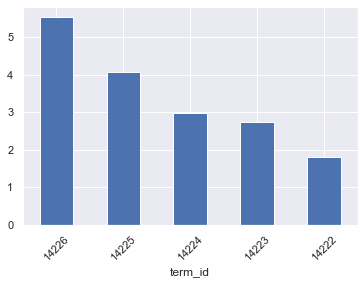

In [43]:
TOPS_b = EIG_PAIRS_b.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)#
EIG_PAIRS_b.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [44]:
TOPS_b.index.name = 'comp_id'

In [45]:
TOPS_b.index = ["PC{}".format(i) for i in TOPS_b.index.tolist()]

**Show loadings**

In [46]:
LOADINGS_b = TOPS_b[TERM_IDX].T
LOADINGS_b.index.name = 'term_id'
LOADINGS_b.head().style.background_gradient()

In [47]:
LOADINGS_b['term_str'] = LOADINGS_b.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)
lb0_pos = LOADINGS_b.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
lb0_neg = LOADINGS_b.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
lb1_pos = LOADINGS_b.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
lb1_neg = LOADINGS_b.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [48]:
print('Books PC0+', lb0_pos)
print('Books PC0-', lb0_neg)
print('Books PC1+', lb1_pos)
print('Books PC1-', lb1_neg)

Books PC0+ hester thou pearl minister prynne thee thy alice dimmesdale scarlet
Books PC0- darcy bingley mr elizabeth bennet jane mrs collins miss wickham
Books PC1+ hester thou pearl minister mr prynne darcy thee thy bingley
Books PC1- alice queen rabbit hatter mouse turtle scrooge gryphon im king


**Project onto document component matrix**

In [49]:
DCM_b = TFIDF_b.dot(TOPS_b[TERM_IDX].T)
DCM_b['label'] = LIB.author
DCM_b['title'] = LIB.title

### LDA

In [50]:
# Configs and imports
n_terms = 4000
n_topics = 30
max_iter = 5
LDAOHCO = ['author', 'title', 'chap_num', 'para_num']

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [51]:
# Merge LIB and TOKEN tables
LIBTOKEN = TOKEN.join(LIB, on='book_id', how='left')

In [52]:
LIBTOKEN = LIBTOKEN.drop(columns=['book_title', 'book_file'])

In [53]:
# Create PARAS dataframe
PARAS = LIBTOKEN[LIBTOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(LDAOHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [54]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()

**LDA model**

In [55]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

**THETA table**

In [56]:
# Create THETA table
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [57]:
# Print THETA table
THETA.sample(5).style.background_gradient()

**PHI table**

In [58]:
# Create PHI table
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [59]:
# Print PHI table
PHI.T.sample(5).style.background_gradient()

**TOPICS table**

In [60]:
# Create TOPICS table
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [61]:
# Print TOPICS table
TOPICS.sample(5)

term_str       0        1      2      3         4       5      6      7  \
topic_id                                                                  
29           sir   father   town  reply   brother    home   aunt   days   
22          thou   mother  child   thee  minister   woman   hast    man   
18            ha      way   deal   good      time  ladies  words    man   
10          time    place   town    eye      life  return  heart    sun   
6         letter  scarlet   eyes  bosom     child   woman  world  death   

term_str        8            9  
topic_id                        
29        country  opportunity  
22            day         hand  
18         father       friend  
10           days          day  
6            face        hands

In [62]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)

### word2vec

In [63]:
# Configs and Imports
from gensim.models import word2vec

BAG = CHAP
window = 5

In [64]:
# Convert to a corpus for Gensim excluding proper nouns.
corpus = TOKEN[~TOKEN.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

**word2vec model**

In [65]:
# Generate word embeddings with Gensim's library
model = word2vec.Word2Vec(corpus, vector_size=246, window=window, min_count=200, workers=4)

### Sentiment Analysis

In [66]:
# Configs
salex_csv = 'salex_nrc.csv'
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo = 'polarity'

**Establish lexicons**

In [67]:
# Get lexicon
salex = pd.read_csv(salex_csv).set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
# Add polarity
salex['polarity'] = salex.positive - salex.negative
# Get lexicon columns
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [68]:
emo_TOKEN = LIBTOKEN.join(salex, on='term_str', how='left')
emo_TOKEN[emo_cols] = emo_TOKEN[emo_cols].fillna(0)
emo_TOKEN[['term_str'] + emo_cols].sample(5)

term_str  anger  anticipation  \
book_id chap_num para_num sent_num token_num                                 
1342    103      15       3        14          openly    0.0           0.0   
84      29       10       2        14            just    0.0           0.0   
25344   13       2        10       6              the    0.0           0.0   
1342    83       7        0        18             may    0.0           0.0   
84      37       4        5        31          tinged    0.0           0.0   

                                              disgust  fear  joy  sadness  \
book_id chap_num para_num sent_num token_num                                
1342    103      15       3        14             0.0   0.0  0.0      0.0   
84      29       10       2        14             0.0   0.0  0.0      0.0   
25344   13       2        10       6              0.0   0.0  0.0      0.0   
1342    83       7        0        18             0.0   0.0  0.0      0.0   
84      37       4        5        31             0.0   0.0  0.0      0.0   

                                              surprise  trust  polarity  
book_id chap_num para_num sent_num token_num                             
1342    103      15       3        14              0.0    0.0       0.0  
84      29       10       2        14              0.0    0.0       0.0  
25344   13       2        10       6               0.0    0.0       0.0  
1342    83       7        0        18              0.0    0.0       0.0  
84      37       4        5        31              0.0    0.0       0.0

**Establish sentiments**

In [69]:
# Set up for chapter sentiment
chapOHCO = OHCO[1:2]
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

In [70]:
# Mean emotion by book
FRANK = emo_TOKEN.loc[84].copy()
PRIDE = emo_TOKEN.loc[1342].copy()
CHRISTMAS = emo_TOKEN.loc[46].copy()
SCARLET = emo_TOKEN.loc[25344].copy()
ALICE = emo_TOKEN.loc[11].copy()

# Sentiment by chapter
FRANK_chaps = FRANK.groupby(chapOHCO)[emo_cols].mean()
PRIDE_chaps = PRIDE.groupby(chapOHCO)[emo_cols].mean()
CHRISTMAS_chaps = CHRISTMAS.groupby(chapOHCO)[emo_cols].mean()
SCARLET_chaps = SCARLET.groupby(chapOHCO)[emo_cols].mean()
ALICE_chaps = ALICE.groupby(chapOHCO)[emo_cols].mean()

### Similarity and Distance Measures

In [71]:
# Collapse TFIDF by book_id
OHCO_b = ['book_id']
DIS_TFIDF = TFIDF.groupby(OHCO_b).mean()

# Create a table from the TFIDF
DIS_DOC = DIS_TFIDF.reset_index()[OHCO_b] 

In [72]:
# Change index to doc_id
DIS_DOC.index.name = 'doc_id'
# Create a new column containing the author and title
DIS_DOC['auth_title'] = DIS_DOC.book_id.map(LIB.author) \
    + ': ' + DIS_DOC.book_id.map(LIB.title)
# Look at sample of data
DIS_DOC.sample(5)

term_id  book_id                                         auth_title
doc_id                                                             
1             46                 Charles Dickens: A Christmas Carol
4          25344            Nathaniel Hawthorne: The Scarlet Letter
2             84   Mary Wollstonecraft (Godwin) Shelley: Franken...
3           1342                   Jane Austen: Pride and Prejudice
0             11    Lewis Carroll: Alice’s Adventures in Wonderland

In [73]:
# Create normalized table
L0 = DIS_TFIDF.astype('bool').astype('int')
L1 = DIS_TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = DIS_TFIDF.apply(lambda x: x / norm(x), 1)

**PAIRS table**

In [74]:
# Create a new table to store our pairs results
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DIS_DOC.index.tolist(), DIS_DOC.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0', 'level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2)]

In [75]:
# Compute distances using different measures
from scipy.spatial.distance import pdist
PAIRS['cityblock'] = pdist(DIS_TFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(DIS_TFIDF, 'euclidean')
PAIRS['cosine'] = pdist(DIS_TFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')
PAIRS['correlation'] = pdist(L1, 'correlation')
PAIRS.sample(5)

cityblock  euclidean    cosine   jaccard      dice        js  \
doc_a doc_b                                                                 
2     4       0.538512   0.010028  0.724397  0.648295  0.479613  0.605638   
0     3       0.504912   0.019973  0.895477  0.786183  0.647695  0.683047   
1     2       0.588962   0.020152  0.888670  0.731658  0.576862  0.663876   
2     3       0.444834   0.007512  0.679280  0.637250  0.467620  0.597227   
0     4       0.644250   0.021282  0.935540  0.820724  0.695956  0.715348   

             correlation  
doc_a doc_b               
2     4         0.884267  
0     3         0.951741  
1     2         0.967787  
2     3         0.837711  
0     4         0.992941

## F6: Visualizations

Visualizations include the TFIDF heat maps, t-SNE plot, sentiment analysis plots for each document, clustring topics in the corpus, and similarity and distance measurement plots.

### TFIDF Heatmaps

The TFIDF heat maps show the frequency of each term in the VOCAB table including the annotations from F4 with the addition of analysis using Zip's K and the tfidf_sum. The values are sorted on the sum of term frequency-inverse doucment frequency value and therefore these are the top 20 terms as part of the corpus. In the first heatmap, it is noted that all of these terms are part of speech "NNP" or proper nouns which makes sense as the authors are often referring to the characters in the novels. Therefore, in the second table we explore the top 50 terms that are not proper nouns.

**Heat map of top 20 terms**

In [76]:
VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap)

**Heatmap of top 20 terms without proper nouns**

In [77]:
# Heatmap of top 20 terms without proper nouns
VOCAB.loc[VOCAB.pos_max != 'NNP', ['term_rank','term_str','pos_max','tfidf_sum']].sort_values('tfidf_sum', ascending=False)\
    .head(20).style.background_gradient(cmap=gradient_cmap, high=.5)

### t-SNE Plot

The t-distributed scholastic neighbor embedding (t-SNE) plot uses the word2vec model to create vecto space representations of each word for which can be plotted on an x-y plane. In the plot we see words that are highly associated with each other are closer in vector space on the plot than words that are not as associated with each other. 

In [78]:
# Configs and Imports
from sklearn.manifold import TSNE

In [79]:
# Generate coordinates to plot
coords = pd.DataFrame(index=range(len(model.wv)))
coords['label'] = [w for w in model.wv.key_to_index]
coords['vector'] = coords['label'].apply(lambda x: model.wv.get_vector(x))
# Fit to t-SNE model
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values = tsne_model.fit_transform(coords['vector'].tolist())
# Get x and y values
coords['x'] = tsne_values[:,0]
coords['y'] = tsne_values[:,1]
# Plot
px.scatter(coords, 'x', 'y', text='label', height=1000).update_traces(mode='text')

### Sentiment Analysis Plots

The sentiment analysis plots are shown for each novel. Here I used 8 emotions with the addition of polarity to describe each novel. The bar plot represents the mean amount of emotion for the book as a whole sorted from greatest to least. For example, the greatest emotion in the novel Alice in Wonderland is joy, while the mean greatest emotion in the novel Frankenstein is fear. The line plot shows the progression of the novel per chapter and the emotions associated with each chapter. As you can see in the plots, some are more fluctuating or stagnant than others.

BOOK: FRANKENSTEIN


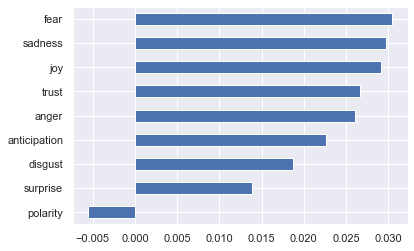

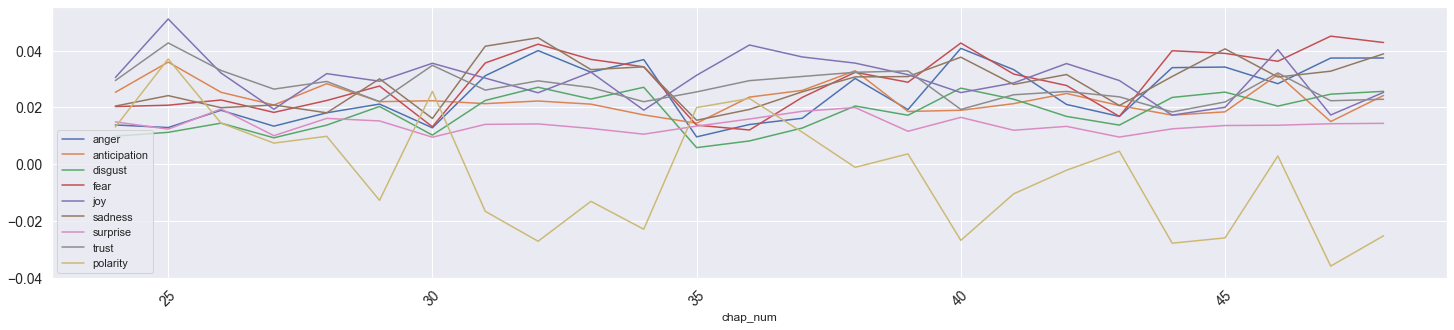

In [80]:
print("BOOK: FRANKENSTEIN")
# Plot mean emotion by book
FRANK[emo_cols].mean().sort_values().plot.barh()
# Pkot sentiment by chapter
plot_sentiments(FRANK_chaps, emo_cols)

BOOK: CHRISTMAS CAROL


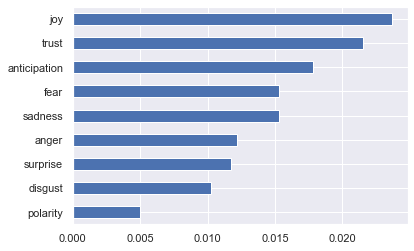

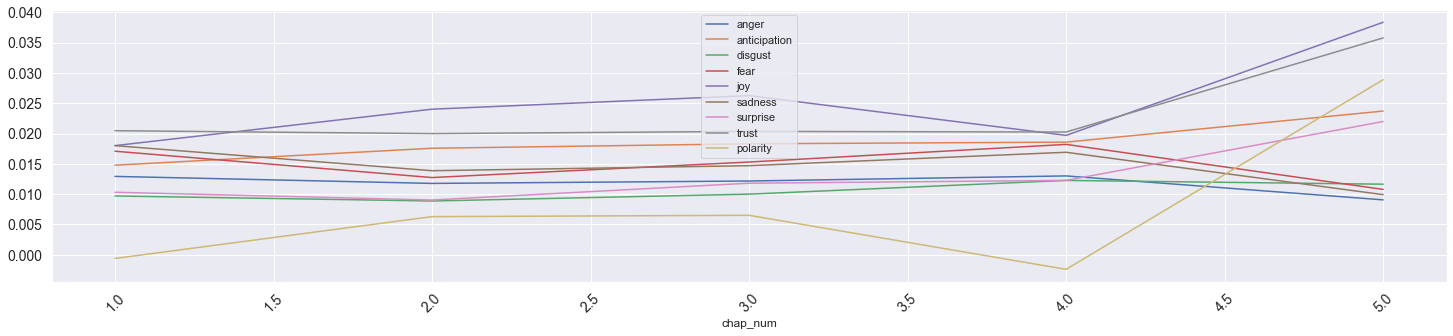

In [81]:
print("BOOK: CHRISTMAS CAROL")
# Plot mean emotion by book
CHRISTMAS[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(CHRISTMAS_chaps, emo_cols)

BOOK: PRIDE AND PREJUDICE


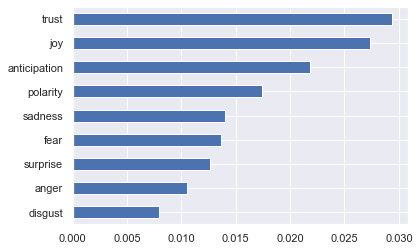

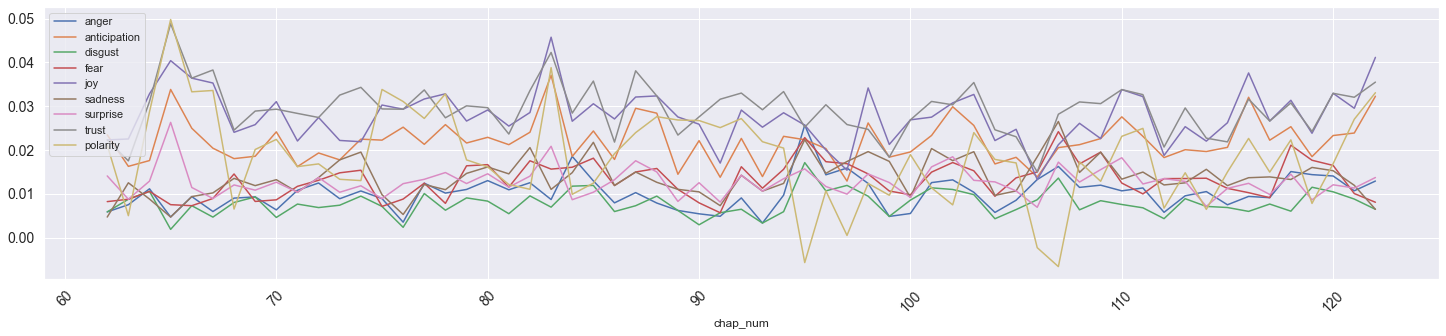

In [82]:
print("BOOK: PRIDE AND PREJUDICE")
# Plot mean emotion by book
PRIDE[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(PRIDE_chaps, emo_cols)

BOOK: SCARLET LETTER


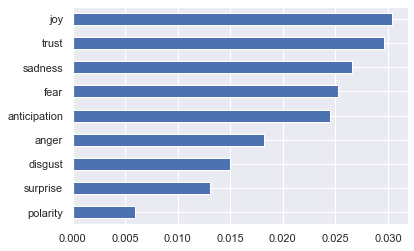

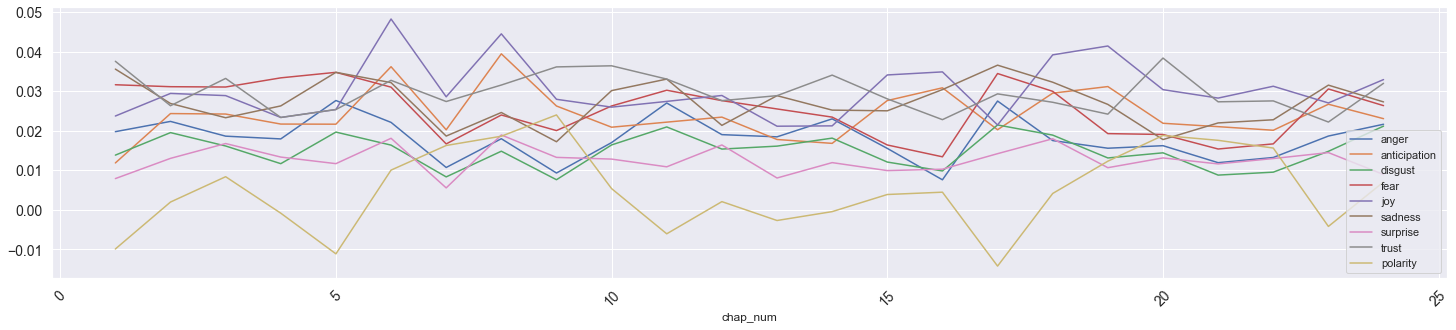

In [83]:
print("BOOK: SCARLET LETTER")
# Plot mean emotion by book
SCARLET[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(SCARLET_chaps, emo_cols)

BOOK: ALICE


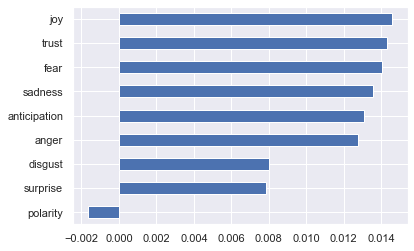

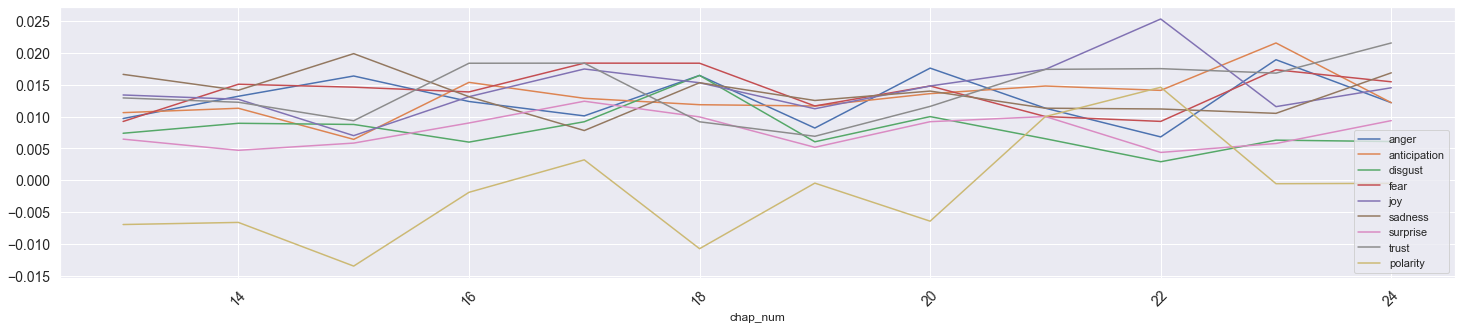

In [84]:
print("BOOK: ALICE")
# Plot mean emotion by book
ALICE[emo_cols].mean().sort_values().plot.barh()
# Plot sentiment by chapter
plot_sentiments(ALICE_chaps, emo_cols)

### Cluster Topics in Corpus

Cluster topics in the corpus by each author. The table shows the THETA table grouped by each author. This is further visualized in the plot tree that shows alike cluster topics in connected branches, close branches, or similar colors than those that are unlike. For example, the purple branches that are near each other is a topic all about child, heart, mother, eyes, beauty compared to the node that is furthest away and indicated in blue at the bottom is a topic containing brother, father, home, opportunity.

In [85]:
# Configs and Imports
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [86]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [87]:
topic_cols = [t for t in range(n_topics)]
# Groupby by each author in using the THETA table
AUTHOR = THETA.groupby('author')[topic_cols].mean().T                                            
AUTHOR.index.name = 'topic_id'

In [88]:
AUTHOR.T

topic_id                                     0         1         2         3   \
author                                                                          
 Charles Dickens                       0.030566  0.036366  0.034585  0.037208   
 Jane Austen                           0.021199  0.032547  0.026034  0.029064   
 Lewis Carroll                         0.023146  0.030605  0.034701  0.051963   
 Mary Wollstonecraft (Godwin) Shelley  0.056675  0.028752  0.046827  0.025122   
 Nathaniel Hawthorne                   0.039191  0.055004  0.024091  0.020296   

topic_id                                     4         5         6         7   \
author                                                                          
 Charles Dickens                       0.032154  0.026275  0.026777  0.036384   
 Jane Austen                           0.045897  0.022209  0.024015  0.013519   
 Lewis Carroll                         0.037576  0.033004  0.032752  0.053901   
 Mary Wollstonecraft (Godwin) Shelley  0.028019  0.024663  0.038994  0.040084   
 Nathaniel Hawthorne                   0.015895  0.033007  0.068046  0.026093   

topic_id                                     8         9   ...        20  \
author                                                     ...             
 Charles Dickens                       0.043719  0.027227  ...  0.033472   
 Jane Austen                           0.041576  0.023831  ...  0.028749   
 Lewis Carroll                         0.033856  0.063187  ...  0.022972   
 Mary Wollstonecraft (Godwin) Shelley  0.023632  0.034959  ...  0.021212   
 Nathaniel Hawthorne                   0.024148  0.026366  ...  0.029269   

topic_id                                     21        22        23        24  \
author                                                                          
 Charles Dickens                       0.047408  0.028431  0.046878  0.025746   
 Jane Austen                           0.029928  0.031065  0.067996  0.050129   
 Lewis Carroll                         0.045069  0.035427  0.042030  0.022240   
 Mary Wollstonecraft (Godwin) Shelley  0.026017  0.018442  0.025506  0.027598   
 Nathaniel Hawthorne                   0.034278  0.135866  0.014800  0.016053   

topic_id                                     25        26        27        28  \
author                                                                          
 Charles Dickens                       0.036303  0.045044  0.029266  0.020463   
 Jane Austen                           0.031171  0.024123  0.040120  0.023271   
 Lewis Carroll                         0.030701  0.039162  0.021823  0.014839   
 Mary Wollstonecraft (Godwin) Shelley  0.032692  0.023725  0.020029  0.038002   
 Nathaniel Hawthorne                   0.019704  0.033700  0.026494  0.060507   

topic_id                                     29  
author                                           
 Charles Dickens                       0.050095  
 Jane Austen                           0.038120  
 Lewis Carroll                         0.039120  
 Mary Wollstonecraft (Godwin) Shelley  0.026661  
 Nathaniel Hawthorne                   0.014177  

[5 rows x 30 columns]

In [89]:
# Add the top terms
AUTHOR['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [90]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [91]:
labels  = ["{}: {}".format(a,b) for a, b in zip(AUTHOR.index,  AUTHOR.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

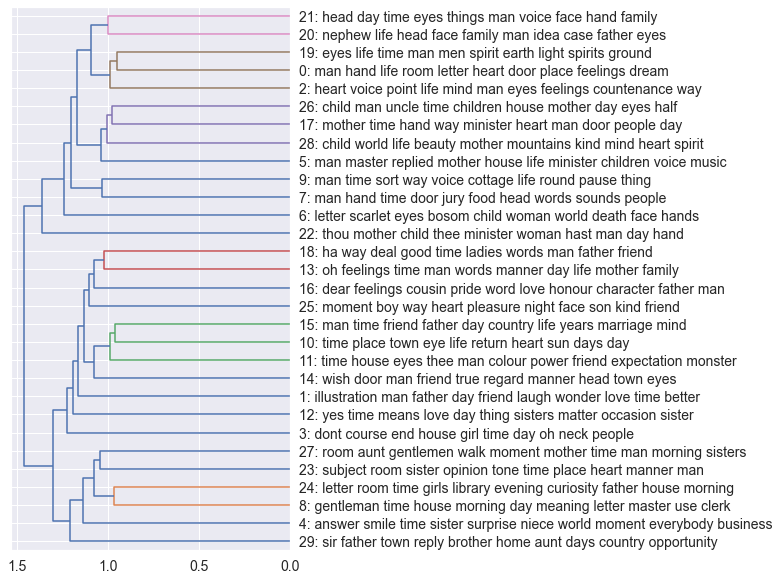

In [92]:
plot_tree(TREE, labels)

### Similarity and Distance Measures

To visualize similarities between documents, the distribution of each distance measurement was sampled and plotted to compare how they are related. Some look to have a strong relationship, while others seem to not indicate much relationship. Next, dendrograms were created using each distance measure to analyze how these novels are related to one another. These shows which document distance relations with branching patterns.

**Compare Distributions**

In [93]:
if PAIRS.shape[0] > 1000:
    SAMPLE = PAIRS.sample(1000)
else:
    SAMPLE = PAIRS

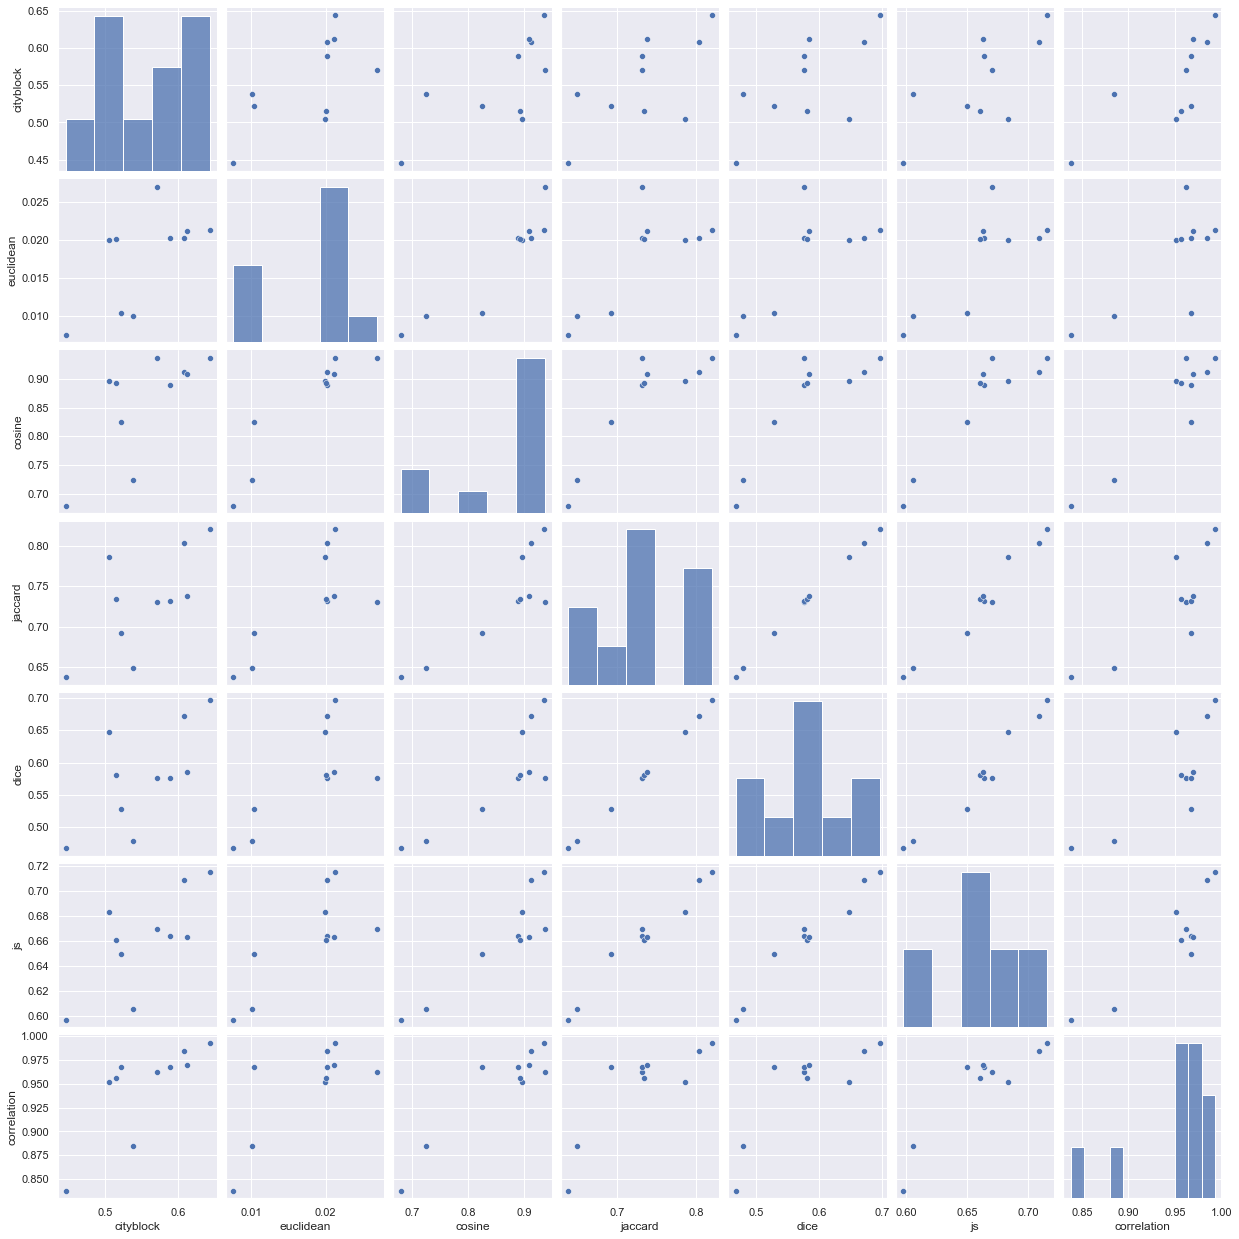

In [94]:
sns.pairplot(SAMPLE)

**Create clusters with dendrograms**

In [95]:
def hca(sims, linkage_method='ward', color_thresh=0.3, figsize=(5, 5)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = DIS_DOC.auth_title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree,
                               labels=labels,
                               orientation='left',
                               count_sort=True,
                               distance_sort=True,
                               above_threshold_color='.75',
                                color_threshold=color_thresh)
    plt.tick_params(axis='both', which='major', labelsize=14)

Distance: Cityblock


<Figure size 432x288 with 0 Axes>

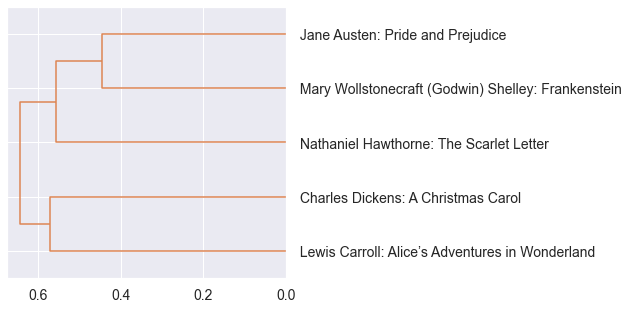

In [112]:
print('Distance: Cityblock')
hca(PAIRS.cityblock, color_thresh=1)

Distance: Euclidean


<Figure size 432x288 with 0 Axes>

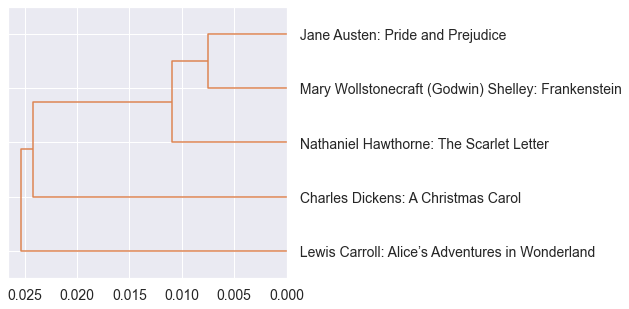

In [113]:
print('Distance: Euclidean')
hca(PAIRS.euclidean, color_thresh=1)

Distance: Cosine


<Figure size 432x288 with 0 Axes>

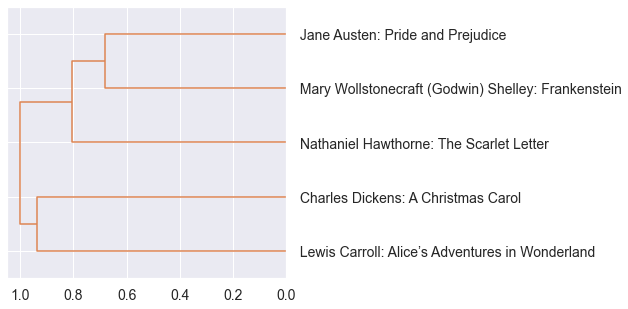

In [114]:
print('Distance: Cosine')
hca(PAIRS.cosine, color_thresh=1)

Distance: Jaccard


<Figure size 432x288 with 0 Axes>

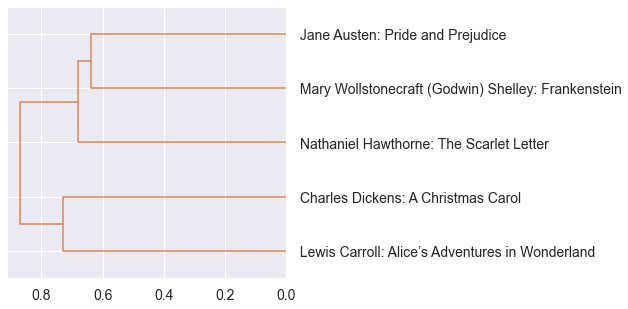

In [115]:
print('Distance: Jaccard')
hca(PAIRS.jaccard, color_thresh=1)

Distance: Dice


<Figure size 432x288 with 0 Axes>

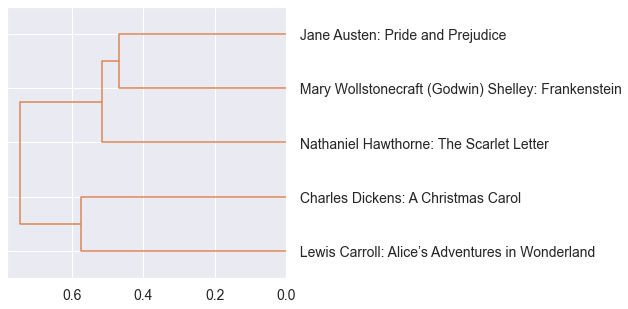

In [116]:
print('Distance: Dice')
hca(PAIRS.dice, color_thresh=1)

Distance: JS


<Figure size 432x288 with 0 Axes>

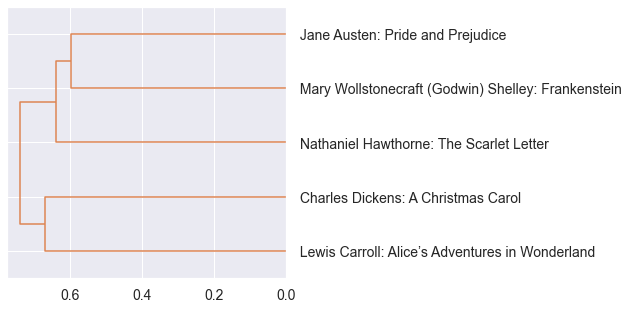

In [117]:
print('Distance: JS')
hca(PAIRS.js, color_thresh=1)

Distance: Correlation


<Figure size 432x288 with 0 Axes>

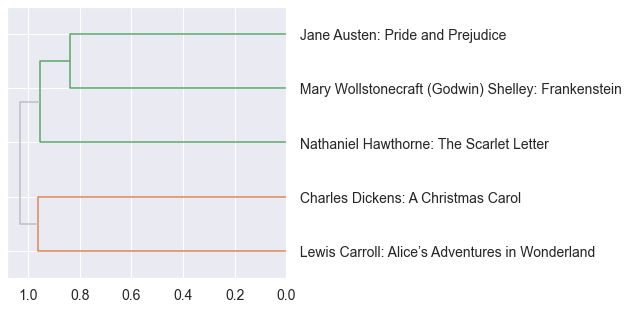

In [102]:
print('Distance: Correlation')
hca(PAIRS.correlation, color_thresh=1)